# Figure 5: Analysis and plotting

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import utils.CaAnaly as CaaN
import utils.Adult_analysis as An
import utils.Pandas_analysis as PdA
import utils.Plotting as Pl
import scipy as sp
import scipy.signal as sps
import sklearn.cluster as sc
from sklearn import metrics
import pandas as pd
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as tukey
import scipy.stats as stats

In [2]:
color1 = '#0cbccc'
color2 = '#107acc'
color3 = '#15297c'
color4 = '#b695b0'
color5 ='#4c007d'


In [3]:
Save_path = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Analysis/Paper_figures/Figure_4/Plots/Final_panels/' 

# Load dataframe

In [4]:
File_name = '2023_10_17_df_adult'
Load_path = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Analysis/Data_frames/'



#Load data
df = pd.read_csv(Load_path + File_name + '.csv')
#Replace coloumn name Animal with animal
df = df.rename(columns={'Animal': 'animal'})

#Remove row 4 because poor vis
df = df.drop(df.index[4])
#Reset index
df = df.reset_index(drop=True)


#Iterate through every row in df, check if the value in column 't007' ends in ' ', if it does, remove the space
for i, row in df.iterrows():
    for r in range(1,8):
        if row['t00'+str(r)][-1] == ' ':
            df.at[i,'t00'+str(r)] = row['t00'+str(r)][:-1]

#Replace any value 'Brush' with 'Multiwhisker'
for i, row in df.iterrows():
    for r in range(1,8):
        if row['t00'+str(r)] == 'Brush':
            df.at[i,'t00'+str(r)] = 'Multiwhisker'
#Same with velcro to smooth
for i, row in df.iterrows():
    for r in range(1,8):
        if row['t00'+str(r)] == 'Velcro':
            df.at[i,'t00'+str(r)] = 'Smooth'
df.head(5)

#From row 36 onwards, replace t007 with 'Sound' and t006 with 'Air puff'
for i, row in df.iterrows():
    for r in range(6,8):
        if i >= 36:
            if r == 7:
                df.at[i,'t00'+str(r)] = 'Sound'
            elif r == 6:
                df.at[i,'t00'+str(r)] = 'Air puff'

In [74]:
# Print sample sizes for each genotype
print('Number of animals in each genotype:')
print(df['Genotype'].value_counts())


Number of animals in each genotype:
HET        13
WT         12
Control     8
KO          5
SSRI        5
Name: Genotype, dtype: int64


## Decoding genotype

In [ ]:
np.random.seed(0)
responses_all = np.empty([1,7, 500, 10, 41])
bins=40
geno_list = []
for i,row in df.iterrows():
    try:
        PeriF = An.periFing(row)
        #Choose 500 random cells
        idx = np.random.choice(PeriF.shape[1],500,replace=False)
        #Pre stim
        pre_stim = np.nanmean(PeriF[:,idx,:,30:45],axis=3)
        # Iterate through post-stim windows of time and calculate the mean difference between pre and post stim, then concatenate across 3 dim
        responses = np.empty([7,500,10,1])
        for i in range(4,bins+4):#44
            # Calculate post stimulus mean on each window
            stim = np.nanmean(PeriF[:,idx,:, 15*i:15*(i+1)],axis=3)
            dif = stim - pre_stim
            responses = np.concatenate((responses,dif[:,:,:,np.newaxis]),axis=3)
        #Concatenate across first dim
        responses_all = np.concatenate((responses_all,responses[np.newaxis,:,:,:,:]),axis=0)
        geno_list.append(row['Genotype'])
        #i multiple of 5 print
        if i%5 == 0:
            print(i)
    except:
        print('Something went wrong with ' + row['filepath'])
        pass






Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-05-22/2023-05-22_GOS3___t-00
Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-05-22/2023-05-22_GOS328_t-00
Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-05-24/2023-05-24_GOS353_t-00
At Sound from GOS349, the sound channel was off -.-


C:\Users\gabrielos\AppData\Local\Temp\ipykernel_513536\1441161350.py:11: RuntimeWarning: Mean of empty slice
  pre_stim = np.nanmean(PeriF[:,idx,:,30:45],axis=3)
C:\Users\gabrielos\AppData\Local\Temp\ipykernel_513536\1441161350.py:16: RuntimeWarning: Mean of empty slice
  stim = np.nanmean(PeriF[:,idx,:, 15*i:15*(i+1)],axis=3)


At Sound from GOS300 stopped, because the times are bigger than the number of frames,
 maybe you forgot to run a trial in suite2p?
At Sound from GOS309 stopped, because the times are bigger than the number of frames,
 maybe you forgot to run a trial in suite2p?
At Sound from GOS306, there are no trials
Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-03-09/2023-03-09_GOS301_t-00
At Sound from GOS280, the sound channel was off -.-
At Sound from GOS282, the sound channel was off -.-
At Sound from GOS278, the sound channel was off -.-
Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-02-12/2023-02-12_GOS278_t-00
At Sound from GOS277, the sound channel was off -.-
At Baseline from GOS279, there are no trials
At Smooth from GOS279, there are no trials
At Sound from GOS279, the sound channel was off -.-
Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-02-11/2023-02-11_GOS279_t-00
At Rough from GOS273, there are no trials


In [9]:
genotypes_comparisons = [['WT','HET','KO'],['Control','WT'],['Control','SSRI'],['WT','SSRI','HET','KO','Control']]
genotypes = ['Control','WT','HET','KO','SSRI']
n_stims = 7
n_bins = 41
Accuracies = np.empty([len(genotypes_comparisons),n_stims,n_bins])

for i, genos in enumerate(genotypes_comparisons):
    Accuracies[i,:,:] = An.genotype_decoding(responses_all,geno_list,genotypes_to_decode = genos)



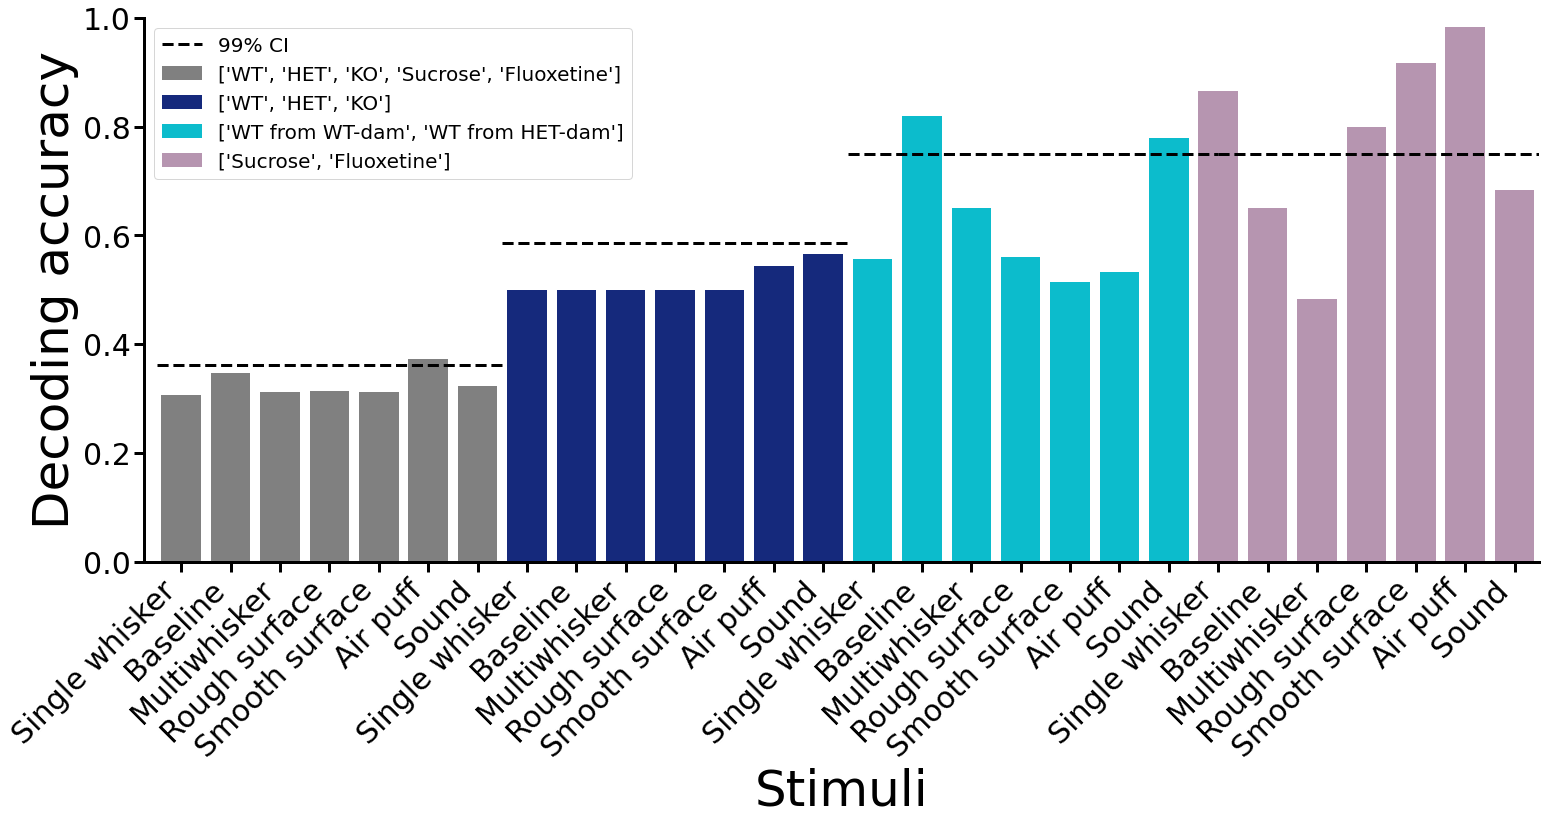

In [552]:
Acc_max = np.max(Accuracies[:,:,:4],axis=2)
# Bar plot all elements of Acc_max 
#Re order Acc_max firs axis as 3,0,1,2
Acc_max = Acc_max[[3,0,1,2],:]
plt.figure(figsize=(25,10))
colors = ['gray',color3,color1,color4]
trials = ['Single whisker','Baseline','Multiwhisker','Rough surface','Smooth surface','Air puff','Sound']
genotypes_comparisons = [['WT','HET','KO','Sucrose','Fluoxetine'],['WT','HET','KO'],['WT from WT-dam','WT from HET-dam'],['Sucrose','Fluoxetine']]
count=0
for i in range(Acc_max.shape[0]):
    
    plt.bar(np.arange(0+count,Acc_max.shape[1]+count),Acc_max[i,:],color=colors[i],label=genotypes_comparisons[i])
    
    #plt.xlabel('Stimulus')
    
    plt.ylim(0,1)
    #plt.title(genotypes_comparisons[i])
    count+=Acc_max.shape[1]
    #plt.savefig(Save_path + 'Decoding_' + str(genotypes_comparisons[i]) + '.png', dpi=300)
    
#Plot horizontal line from 8 to 22 at height 0.75 black dashed
plt.hlines(0.75,21,27.5,linestyle='dashed',color='black', label='99% CI',lw=3)
plt.hlines(0.75,13.5,21,linestyle='dashed',color='black',lw=3)
#gRAY LINE at 0.33
#plt.hlines(0.5,8,22,linestyle='dashed',color='gray')
#Plot horizontal line from 1 to 7 at height 0.586 black dashed
plt.hlines(0.586,6.5,13.5,linestyle='dashed',color='black',lw=3)
#Plot horizontal line from 23 to 29 at height 0.362 black dashed
plt.hlines(0.362,-0.5,6.5,linestyle='dashed',color='black',lw=3)

plt.ylabel('Decoding accuracy', fontsize=50)
plt.xticks(np.arange(0,28,1),trials*4,rotation=45,fontsize=20,ha='right')
plt.legend(fontsize=20)
#Remove top and right spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#Make axis thicker
plt.gca().spines['left'].set_linewidth(3)
plt.gca().spines['bottom'].set_linewidth(3)
#Make ticks thicker
plt.gca().tick_params(width=3)
plt.gca().tick_params(length=10)
plt.gca().tick_params(labelsize=30)
plt.xlabel('Stimuli', fontsize=50)
plt.xlim(-0.75,27.5)
plt.savefig(Save_path + 'Decoding_genotypes_accuracies.svg', dpi=300,bbox_inches='tight',format='svg')

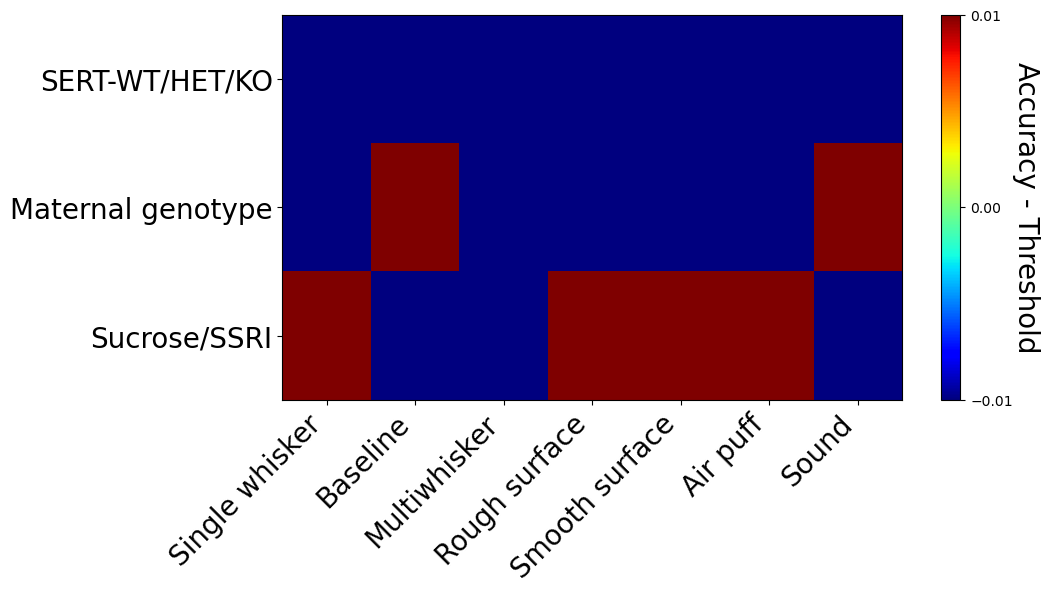

In [71]:
#Plot heat map of Acc_max
#load Acc_max
Acc_max_heat_map = np.load(Save_path + 'Decoding_genotypes_accuracies.npy')
#Normalize by significance threshold by substraction, first row 0.362, second row 0.586, third row 0.75 and fourth row 0.75
Acc_max_heat_map[0,:] = Acc_max_heat_map[0,:] - 0.362
Acc_max_heat_map[1,:] = Acc_max_heat_map[1,:] - 0.586
Acc_max_heat_map[2,:] = Acc_max_heat_map[2,:] - 0.75
Acc_max_heat_map[3,:] = Acc_max_heat_map[3,:] - 0.75

#Remove first row 
Acc_max_heat_map = Acc_max_heat_map[1:,:]
plt.figure(figsize=(10,5))
#Heat map jet
plt.imshow(Acc_max_heat_map,aspect='auto',cmap='jet', vmin = -0.01 , vmax = 0.01)
colorbar = plt.colorbar()
colorbar.set_label('Accuracy - Threshold', rotation=270,labelpad=20,fontsize=20)
#Colorbar ticks
colorbar.set_ticks([-0.01,0,0.01])
plt.xticks(np.arange(0,7,1),trials,rotation=45,fontsize=20,ha='right')
plt.yticks(np.arange(0,3,1),['SERT-WT/HET/KO','Maternal genotype','Sucrose/SSRI'],fontsize=20)

#Xlabel
#plt.xlabel('Stimulus', fontsize=20)

#Savefig
plt.savefig(Save_path + 'Decoding_genotypes_accuracies_heat_map_low_range.svg', dpi=300,bbox_inches='tight',format='svg')




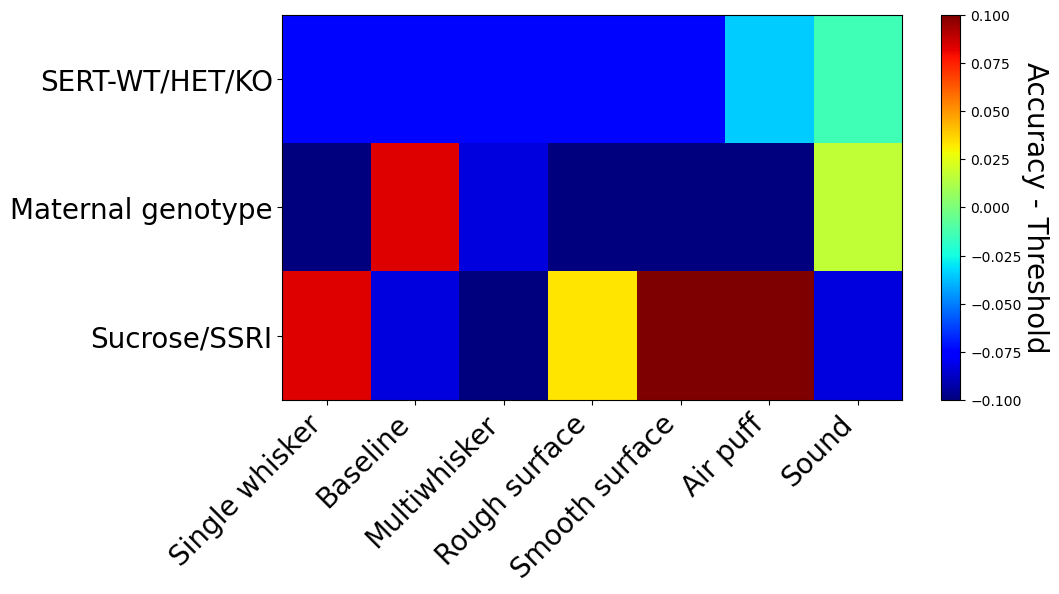

In [72]:
#Plot heat map of Acc_max
#load Acc_max
Acc_max_heat_map = np.load(Save_path + 'Decoding_genotypes_accuracies.npy')
#Normalize by significance threshold by substraction, first row 0.362, second row 0.586, third row 0.75 and fourth row 0.75
Acc_max_heat_map[0,:] = Acc_max_heat_map[0,:] - 0.362
Acc_max_heat_map[1,:] = Acc_max_heat_map[1,:] - 0.586
Acc_max_heat_map[2,:] = Acc_max_heat_map[2,:] - 0.75
Acc_max_heat_map[3,:] = Acc_max_heat_map[3,:] - 0.75

#Remove first row 
Acc_max_heat_map = Acc_max_heat_map[1:,:]
plt.figure(figsize=(10,5))
#Heat map jet
plt.imshow(Acc_max_heat_map,aspect='auto',cmap='jet', vmin = -0.1 , vmax = 0.1)
colorbar = plt.colorbar()
colorbar.set_label('Accuracy - Threshold', rotation=270,labelpad=20,fontsize=20)
#Colorbar ticks
#colorbar.set_ticks([-0.01,0,0.01])
plt.xticks(np.arange(0,7,1),trials,rotation=45,fontsize=20,ha='right')
plt.yticks(np.arange(0,3,1),['SERT-WT/HET/KO','Maternal genotype','Sucrose/SSRI'],fontsize=20)

#Xlabel
#plt.xlabel('Stimulus', fontsize=20)

#Savefig
plt.savefig(Save_path + 'Decoding_genotypes_accuracies_heat_map_high_range.svg', dpi=300,bbox_inches='tight',format='svg')




## Decoding stim type

In [ ]:
#Without averaging the arrays are >200 Mb each given a shape of ~ (7, 1013, 10, 370). Not necessary for now, but you'll need to re-run for decoding or population analysis
def plot_nobins(row):
    try:
        PeriF = An.periFing(row)
        #Remove 1 and 6 from F
        #F = PeriF.copy() #[[0,2,3,4,5],:,:,:]

        idx = np.random.choice(PeriF.shape[1],500,replace=False)
        trial_number= [0,1,2,3,4,5,6][:] # [0,2,3,4,5][:]
        target_labels = np.array([trial_number[i] for i in range(len(trial_number)) for j in range(10)])


        #from sklearn.utils import shuffle

        meanF = PeriF[:,idx,:,:]

        #Reshape as 70, 922
        meanF = np.reshape(meanF,[meanF.shape[0]*meanF.shape[2],meanF.shape[1]*meanF.shape[3]])


        #Remove full rows of nans in dimension 2
        #target_labels = target_labels[:,~np.isnan(meanF).any(axis=(0))]
        meanF = meanF[:,~np.isnan(meanF).any(axis=(0))]


        accuracy = An.decoding(meanF,target_labels)

        return accuracy
    except:
        print('Something went wrong with ' + row['filepath'])
        return np.nan   

df = An.folder_iteration(df,'Accuracy_all_no_bins',plot_nobins) #periFing)

Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-05-22/2023-05-22_GOS3___t-00
Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-05-22/2023-05-22_GOS328_t-00
Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-05-24/2023-05-24_GOS353_t-00
At Sound from GOS349, the sound channel was off -.-
Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-05-30/2023-05-30_GOS349_t-00
At Sound from GOS300 stopped, because the times are bigger than the number of frames,
 maybe you forgot to run a trial in suite2p?
Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-04-04/2023-04-04_GOS300_t-00
At Sound from GOS309 stopped, because the times are bigger than the number of frames,
 maybe you forgot to run a trial in suite2p?
Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-04-03/2023-04-03_GOS309_t-00
At Sound from GOS306, there are no trials
Something went wrong with //qnap

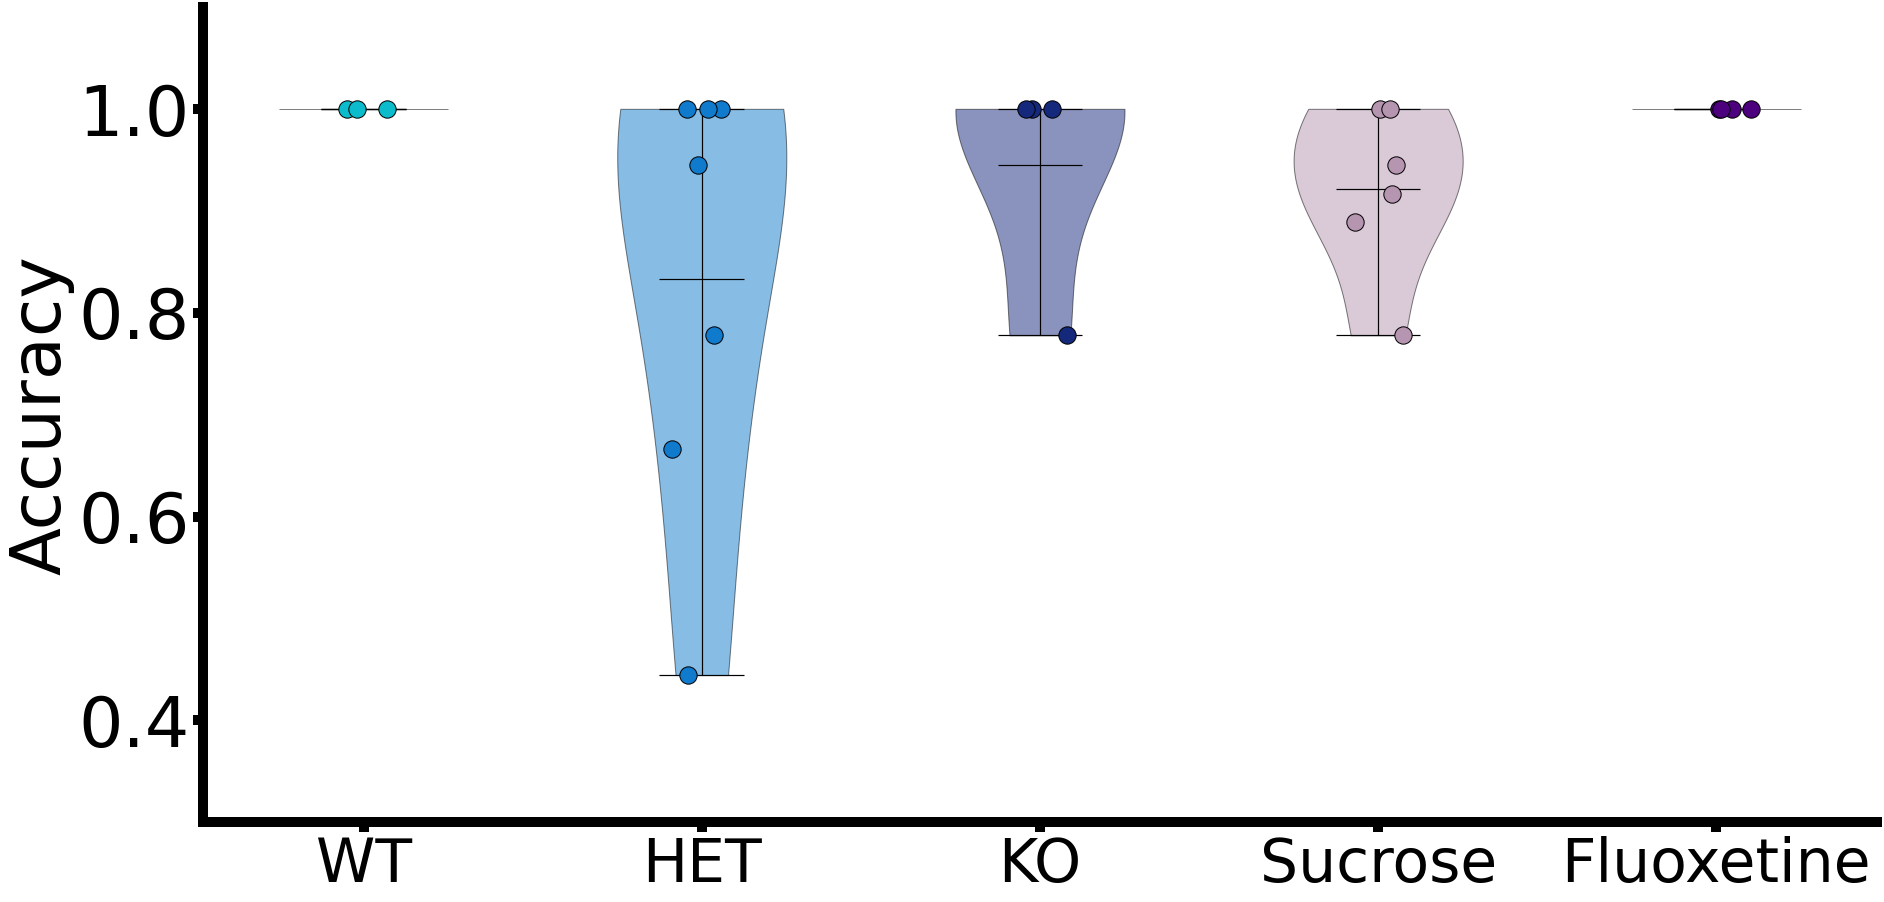

In [ ]:
# Iterate through data frame and scatter Resp decoding values with x as the stim type, y the accuracu and color the genotyep, jitter
#remove none values

df_tmp2 = df2[df2['Accuracy_all_no_bins'] != None]
#Change Genotype column name to genotype
df_tmp2 = df_tmp2.rename(columns={'Genotype': 'genotype'})
#Remove nans
df_tmp2 = df_tmp2[df_tmp2['Accuracy_all_no_bins'].notna()]
colors = [color1,color2,color3,color4,color5]
genotypes = ['WT','HET','KO','Control','SSRI']
plt.figure(figsize=(30,15))

PdA.violin_plot(df_tmp2,'Accuracy_all_no_bins',genotypes=genotypes,color=colors,y_label='Accuracy', var = 0.08,size=300)
plt.xticks(np.arange(1, len(genotypes)+1, step=1),['WT','HET','KO','Sucrose','Fluoxetine'],fontsize=60)
plt.ylim([0.3,1.1])
#Straight horizontal line

plt.savefig(Save_path + 'Multi_stim_class_Accuracy_across_time.svg',bbox_inches='tight',dpi = 300,format='svg')



In [ ]:
import scipy.stats as stats
#Shapiro for accuracy
print(stats.shapiro(df_tmp2['Accuracy_all_no_bins'].values))
#krustal wallis for accuracy of each genotype
stats.kruskal(df_tmp2[df_tmp2['genotype'] == 'WT']['Accuracy_all_no_bins'].values,df_tmp2[df_tmp2['genotype'] == 'HET']['Accuracy_all_no_bins'].values,df_tmp2[df_tmp2['genotype'] == 'KO']['Accuracy_all_no_bins'].values,df_tmp2[df_tmp2['genotype'] == 'Control']['Accuracy_all_no_bins'].values,df_tmp2[df_tmp2['genotype'] == 'SSRI']['Accuracy_all_no_bins'].values)

ShapiroResult(statistic=0.6371186971664429, pvalue=5.788257908534433e-07)


KruskalResult(statistic=7.348952574919967, pvalue=0.11855726868970863)

## Traces

In [5]:
#Without averaging the arrays are >200 Mb each given a shape of ~ (7, 1013, 10, 370). Not necessary for now, but you'll need to re-run for decoding or population analysis
def plot_(row):
    try:
        PeriF = An.periFing(row)
    except:
        print('Something went wrong with ' + row['filepath'])
        return np.nan
    return PeriF#np.nanmean(PeriF,axis=(1,2))
df = An.folder_iteration(df,'PeriF_av',plot_) #periFing)

At Sound from GOS349, the sound channel was off -.-
At Sound from GOS300 stopped, because the times are bigger than the number of frames,
 maybe you forgot to run a trial in suite2p?
At Sound from GOS309 stopped, because the times are bigger than the number of frames,
 maybe you forgot to run a trial in suite2p?
At Sound from GOS306, there are no trials
At Air puff from GOS301, there are no trials
At Sound from GOS301, there are no trials
At Sound from GOS280, the sound channel was off -.-
At Sound from GOS282, the sound channel was off -.-
At Sound from GOS278, the sound channel was off -.-
At Sound from GOS277, the sound channel was off -.-
At Baseline from GOS279, there are no trials
At Smooth from GOS279, there are no trials
At Sound from GOS279, the sound channel was off -.-
At Rough from GOS273, there are no trials
At Sound from GOS273, the sound channel was off -.-
At Sound from GOS271, the sound channel was off -.-
At Baseline from GOS269, there are no trials
At Sound from GOS2

In [6]:
#Without averaging the arrays are >200 Mb each given a shape of ~ (7, 1013, 10, 370). Not necessary for now, but you'll need to re-run for decoding or population analysis
def corre(row):
    try:
        tmp = row['PeriF_av'] 
        corr = np.zeros(7)
        corr[corr == 0] = np.nan
        for i in range(7):
            corr[i] = np.nanmean(np.corrcoef(np.nanmean(tmp[i,:,:,60:210],axis=1)))
    except:
        print('Something went wrong with ' + row['filepath'])
        return np.nan
    return corr#np.nanmean(PeriF,axis=(1,2))
df = An.folder_iteration(df,'Corr',corre) #periFing)

C:\Users\gabrielos\AppData\Local\Temp\ipykernel_74276\1509322400.py:8: RuntimeWarning: Mean of empty slice
  corr[i] = np.nanmean(np.corrcoef(np.nanmean(tmp[i,:,:,60:210],axis=1)))


In [7]:
for i in range(7):
    df = PdA.extract_to_separate_coloumn(df,'Corr',i,'Corr'+str(i))

In [8]:
#REmove perif_av and Corr columns and save data frame
df_tmp =df.copy()
df_tmp = df_tmp.rename(columns={'Genotype': 'genotype'})
df_tmp = df_tmp.drop(columns=['PeriF_av','Corr'])
df_tmp.to_csv(Load_path + '2024_11_16_df_adult_corr.csv',index=False)


In [18]:
import scikit_posthocs as sp

Corr0
ShapiroResult(statistic=0.7308475971221924, pvalue=1.5621417048805597e-07)
KruskalResult(statistic=8.010818832330472, pvalue=0.09118268974799278)
F_onewayResult(statistic=3.307955094643424, pvalue=0.020230832627007776)
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Control    HET  -0.0197 0.9907  -0.143  0.1036  False
Control     KO   0.0013    1.0 -0.1551  0.1578  False
Control   SSRI   0.1558 0.0515 -0.0007  0.3122  False
Control     WT  -0.0052    1.0 -0.1304  0.1201  False
    HET     KO    0.021 0.9934 -0.1234  0.1654  False
    HET   SSRI   0.1754 0.0106   0.031  0.3199   True
    HET     WT   0.0145 0.9955 -0.0953  0.1244  False
     KO   SSRI   0.1544 0.1013 -0.0191   0.328  False
     KO     WT  -0.0065 0.9999 -0.1526  0.1396  False
   SSRI     WT  -0.1609 0.0246  -0.307 -0.0148   True
-----------------------------------------------------
         Control   

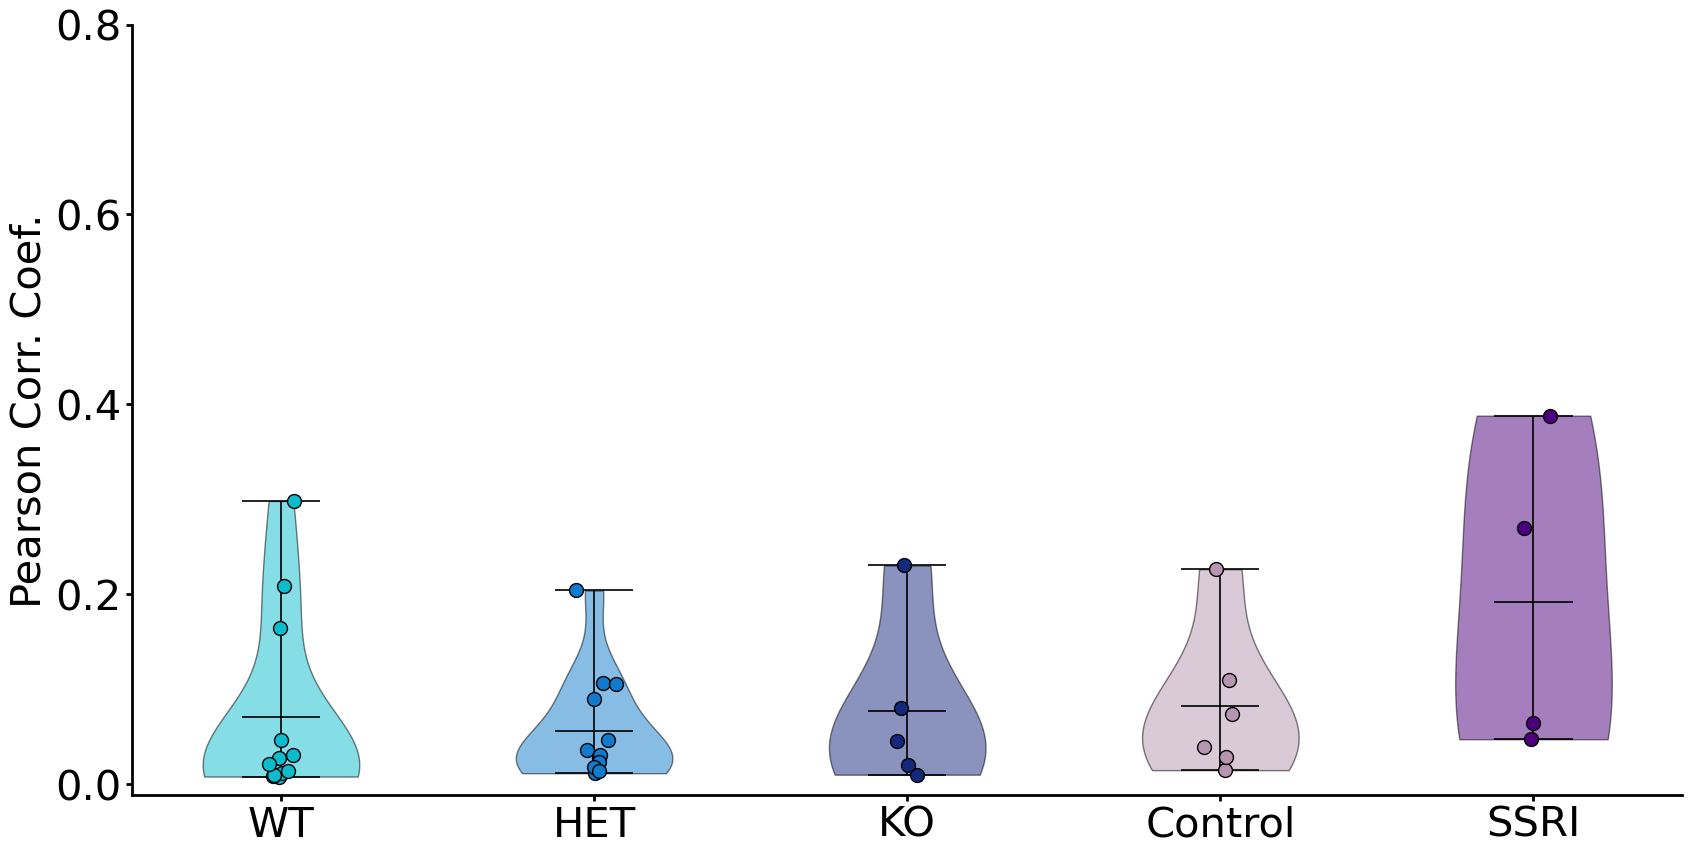

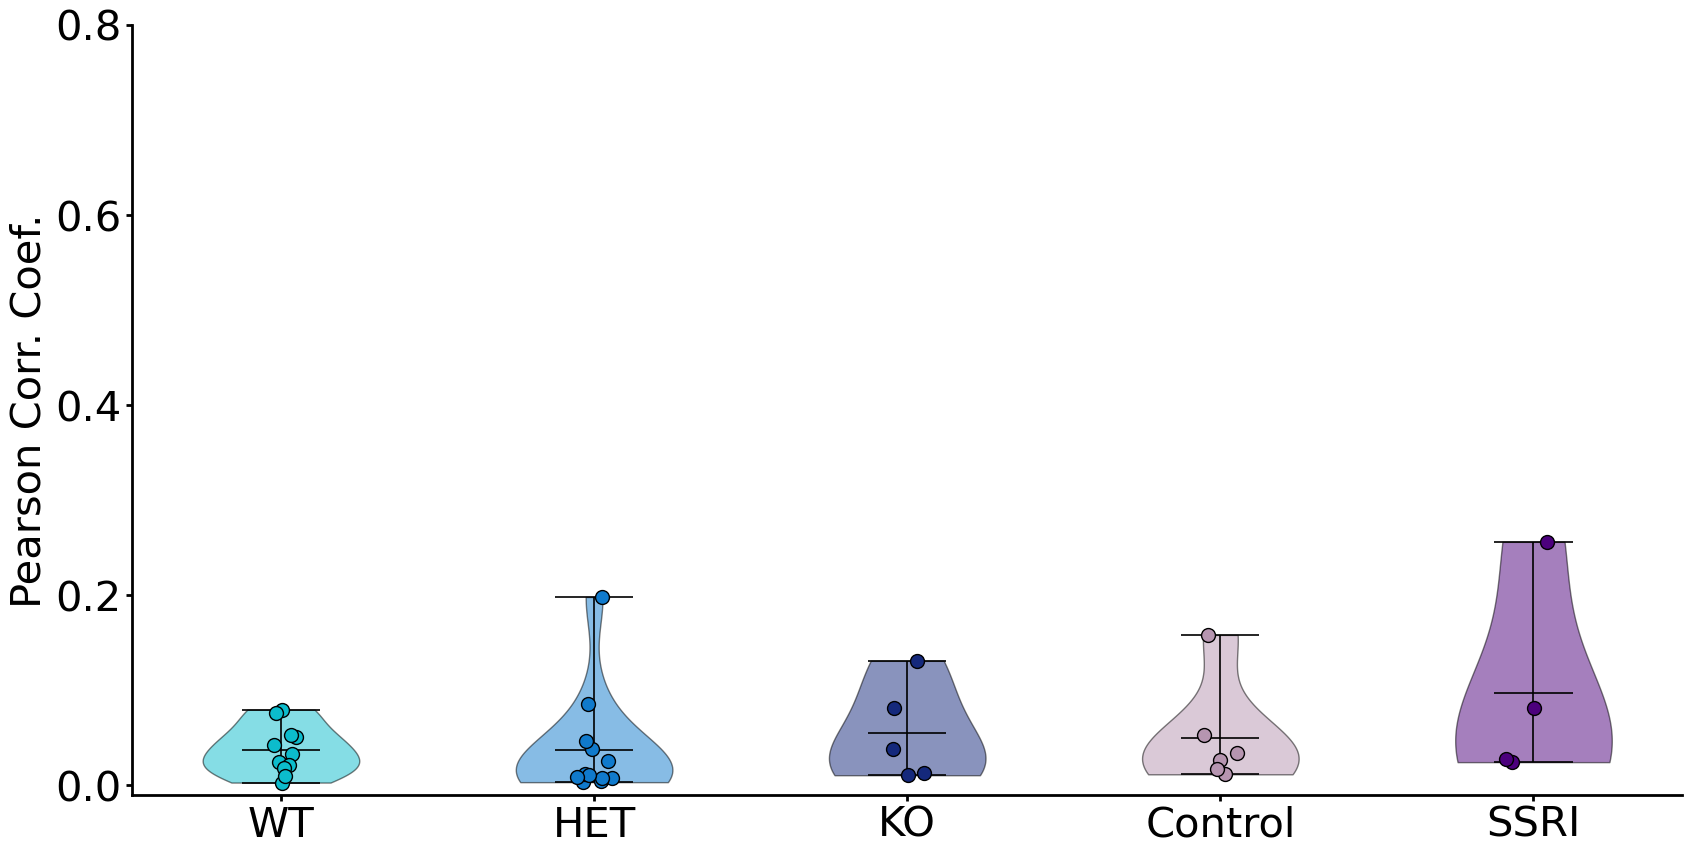

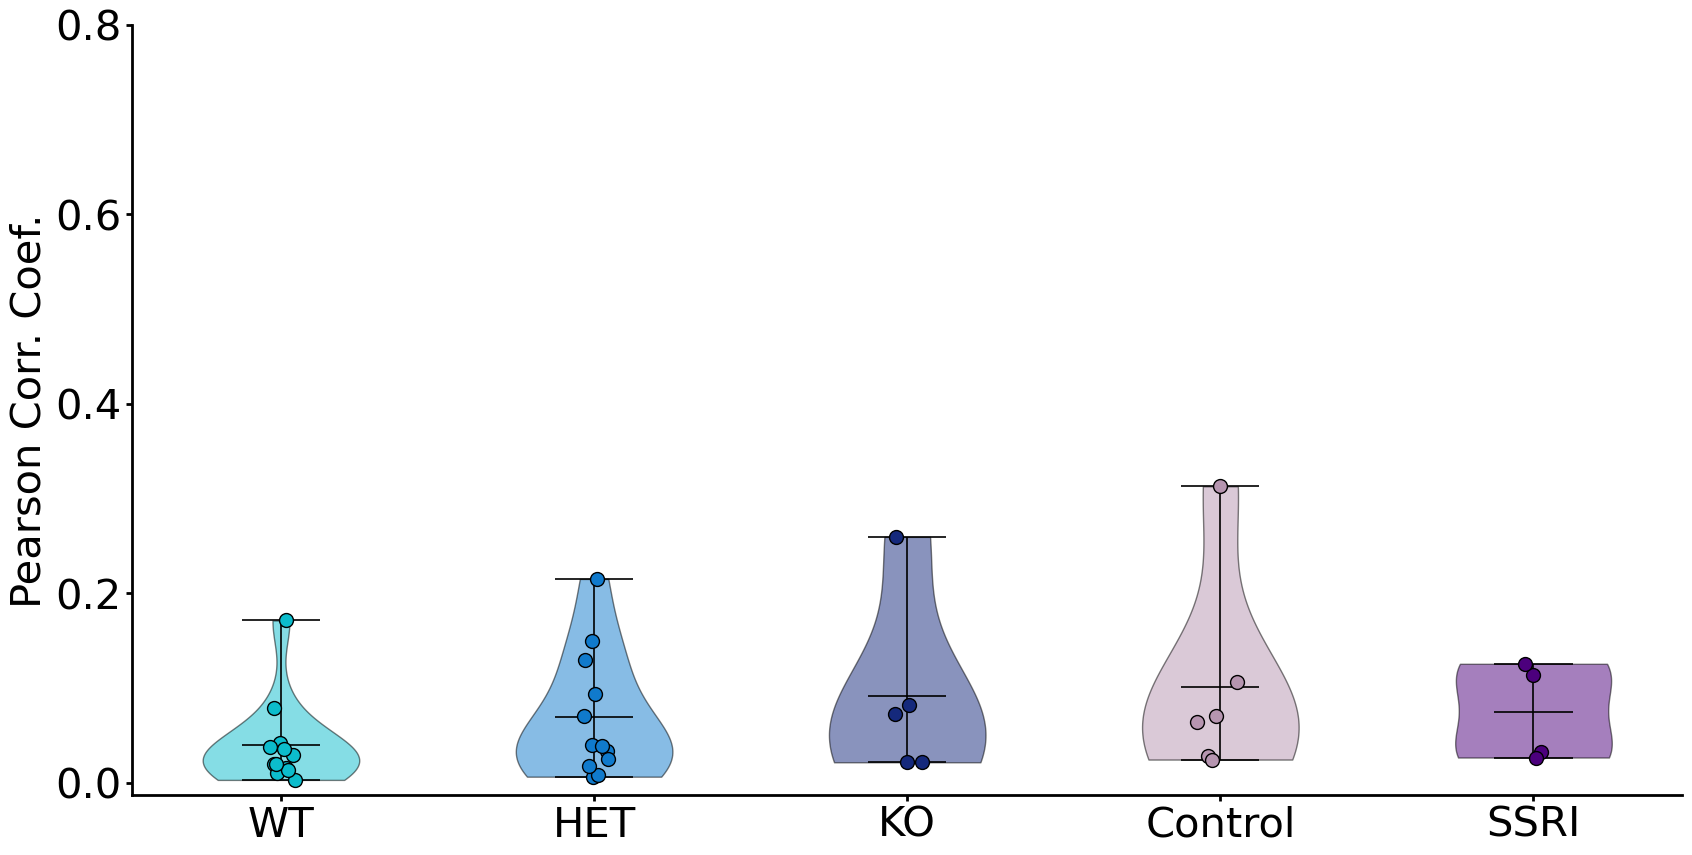

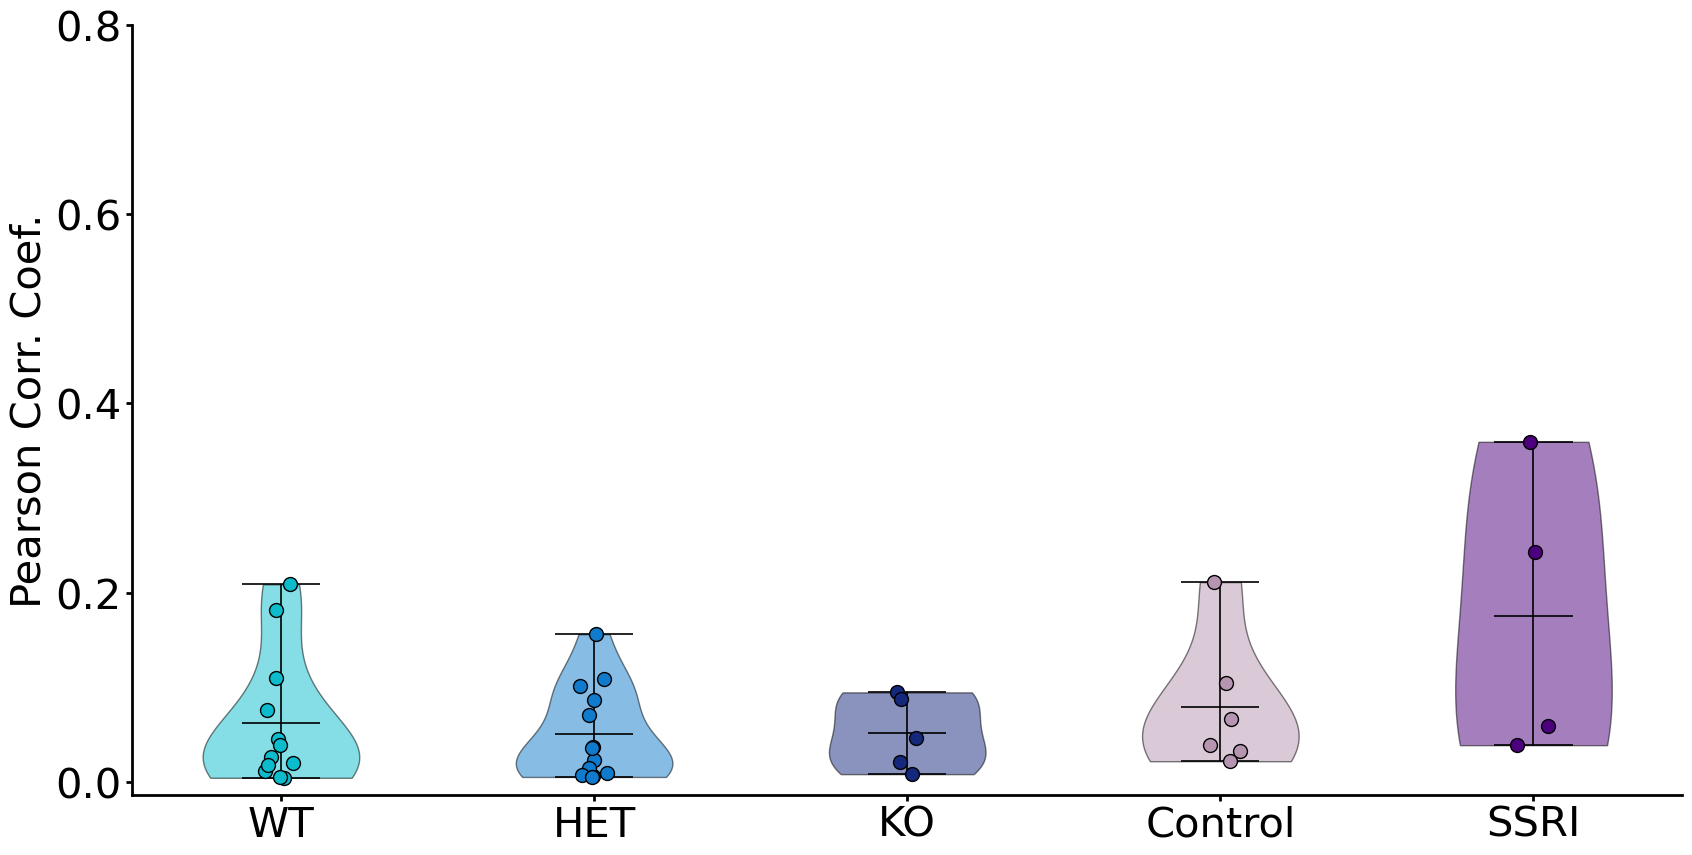

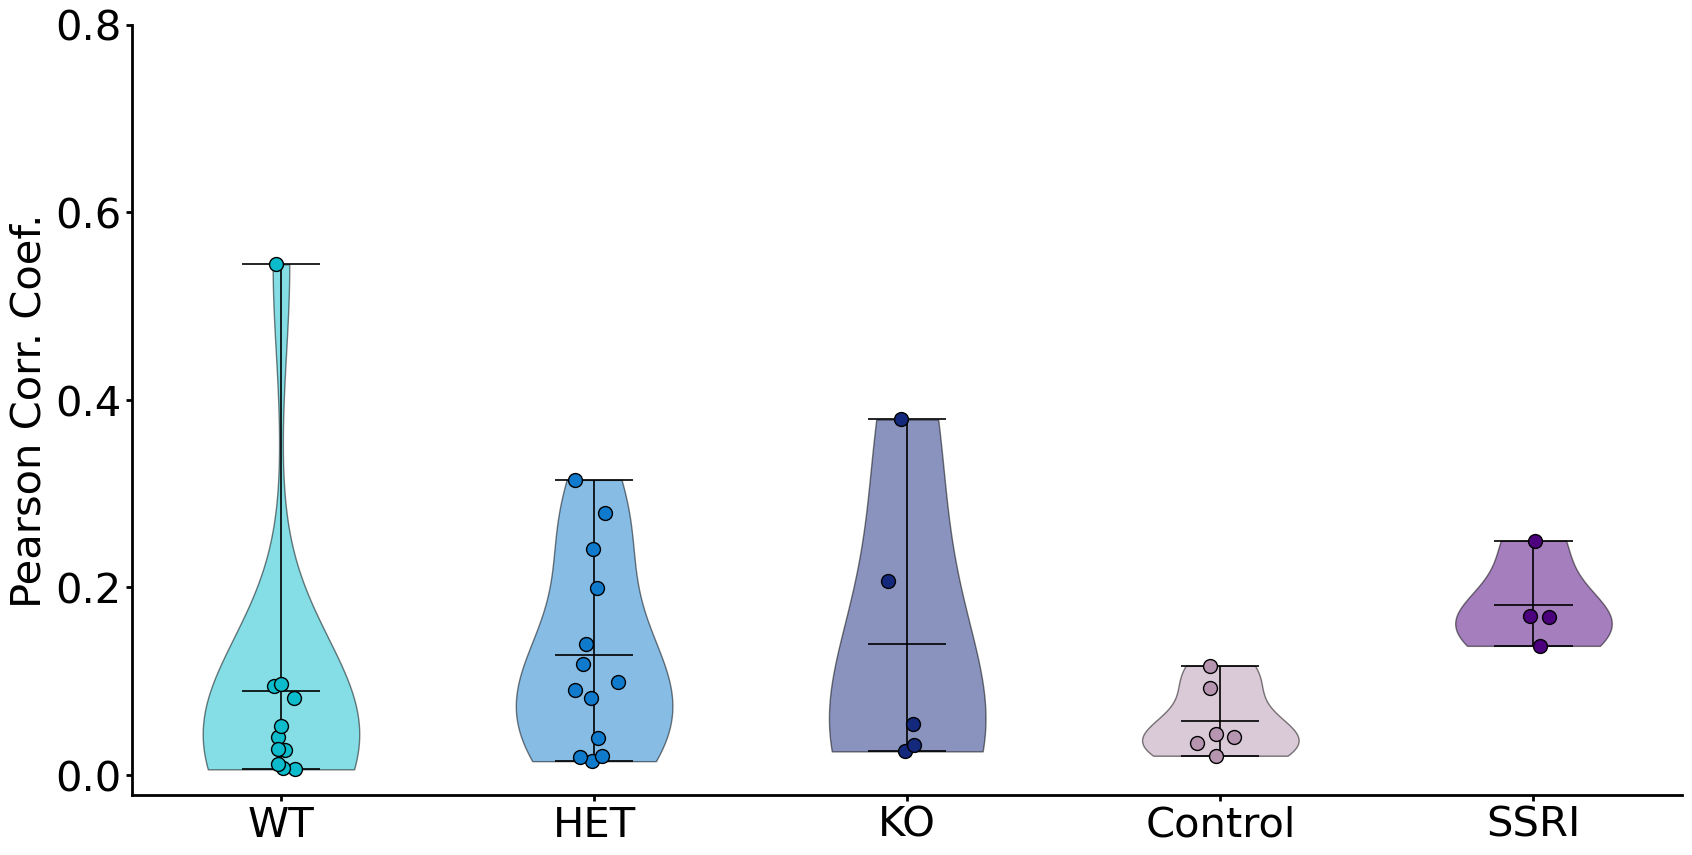

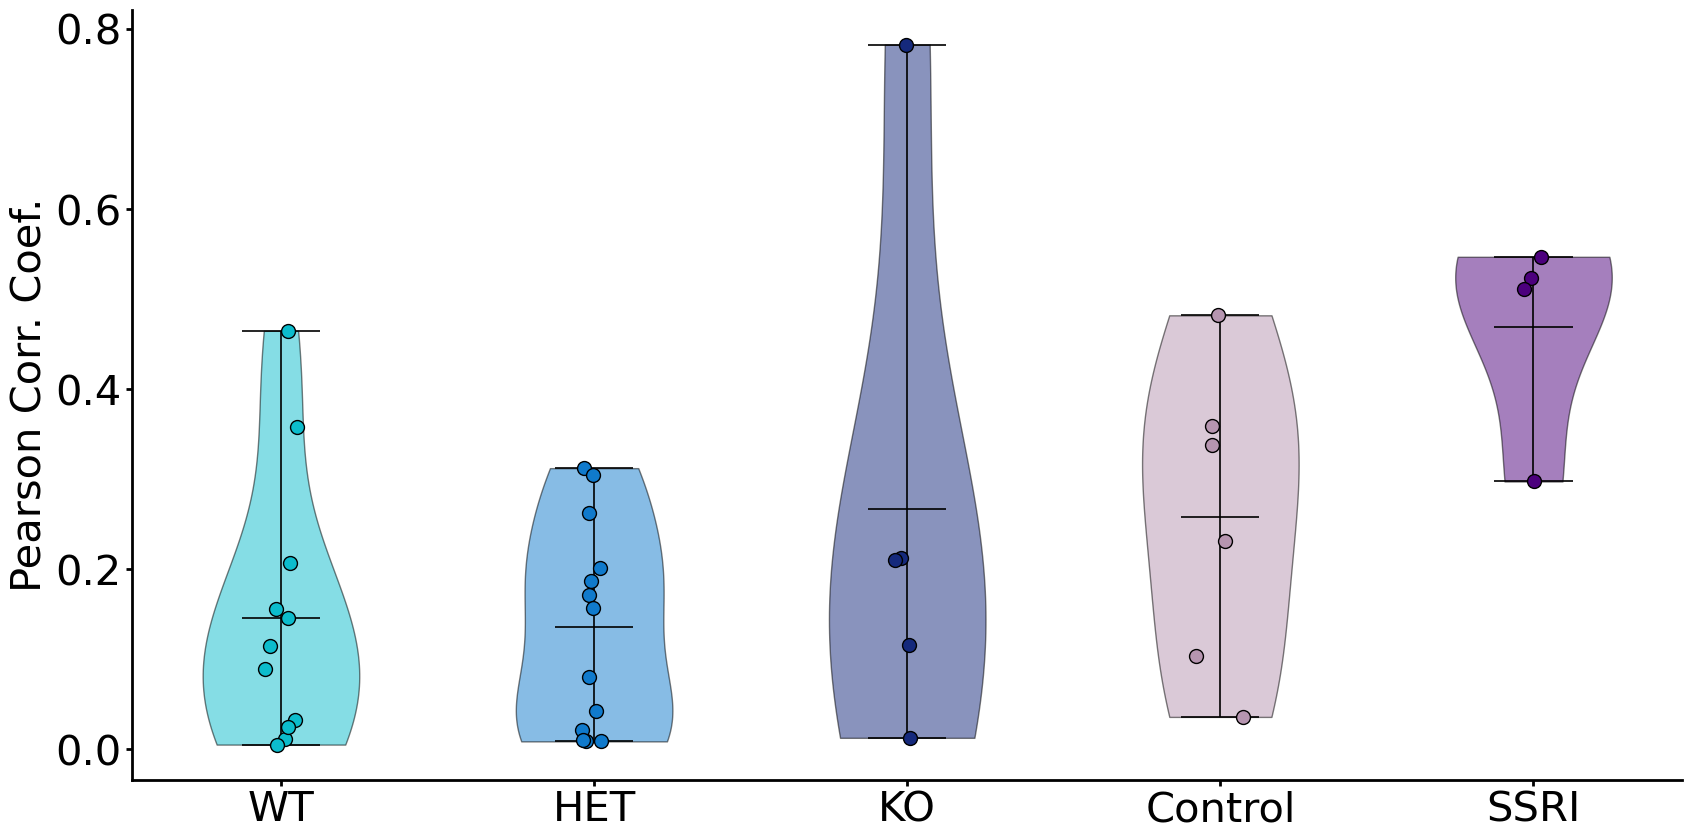

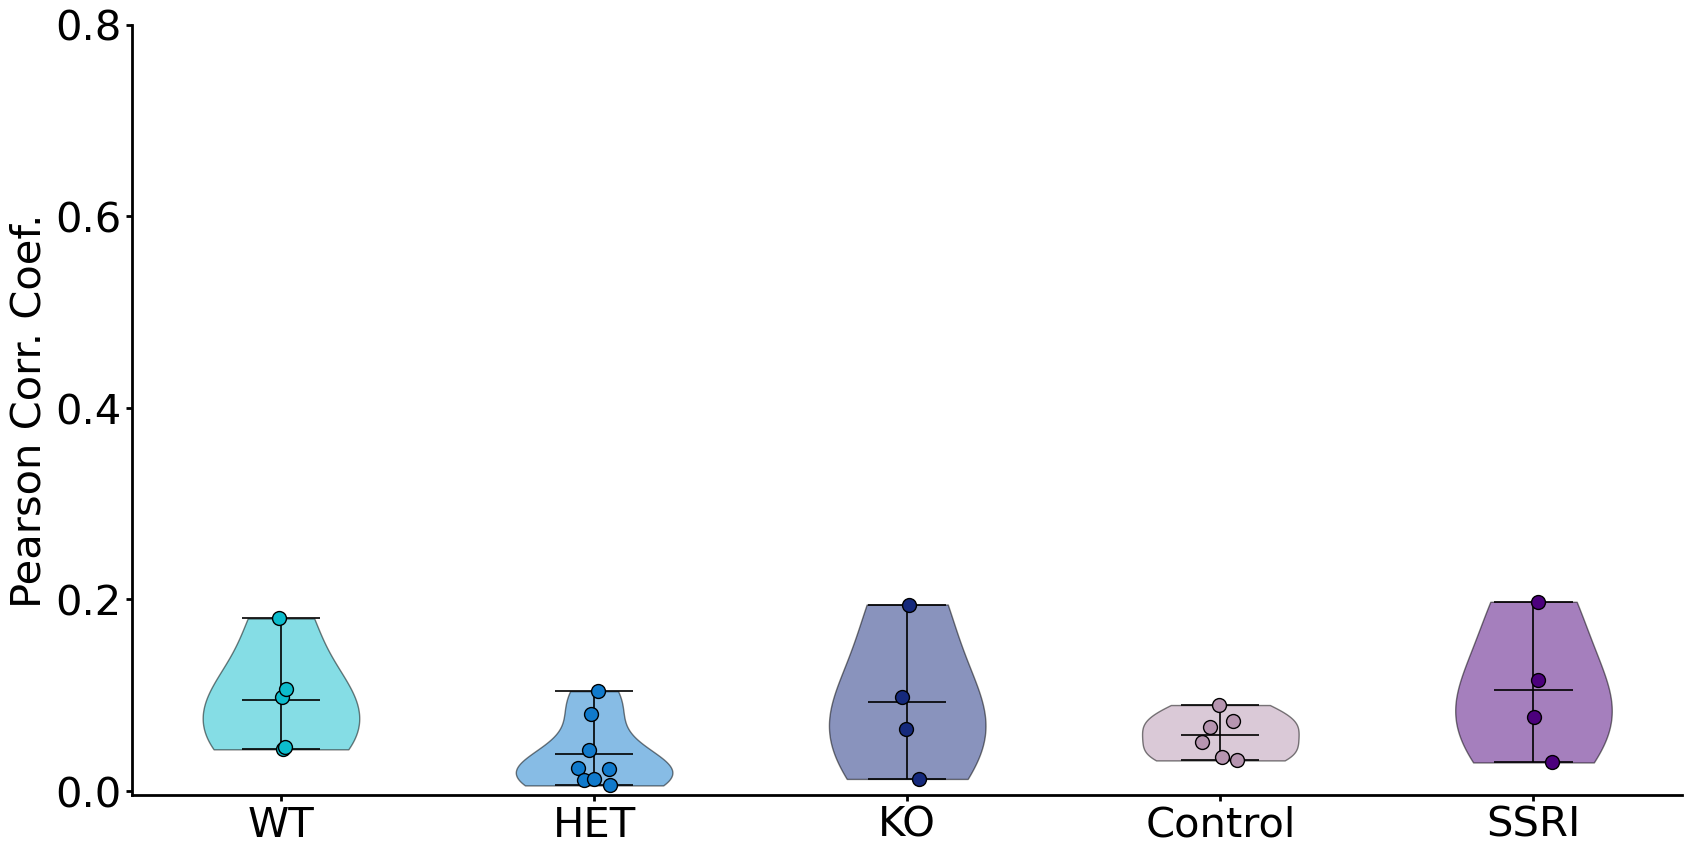

In [118]:
Save_path = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Analysis/Paper_figures/Rebuttals/' 
#df_tmp =df.copy()
#df_tmp = df_tmp.rename(columns={'Genotype': 'genotype'})
for i in range(7):
    df_tmp =df.copy()
    df_tmp = df_tmp.rename(columns={'Genotype': 'genotype'})
    #remove nans in 'Corr' ~+str(i)
    df_tmp = df_tmp[df_tmp['Corr'+str(i)].notna()]
    plt.figure(figsize=(20,10))
    PdA.violin_plot(df_tmp,'Corr' + str(i) ,genotypes = ['WT','HET','KO','Control','SSRI'],y_label ='Pearson Corr. Coef.',color = [color1,color2,color3,color4,color5],fontsize=30)
    #Make lines thinner
    plt.gca().spines['left'].set_linewidth(2)
    plt.gca().spines['bottom'].set_linewidth(2)
    #Make ticks thicker
    plt.gca().tick_params(width=2,length=4)
    plt.yticks(np.arange(0,0.81,0.2),fontsize=30)
    plt.savefig(Save_path + 'Corr' + str(i) + '.svg',bbox_inches='tight',dpi = 300,format='svg')
    
    #stats, anova 
    print('Corr' + str(i))
    print(stats.shapiro(df_tmp['Corr'+str(i)].values))
    print(stats.kruskal(df_tmp[df_tmp['genotype'] == 'WT']['Corr'+str(i)].values,df_tmp[df_tmp['genotype'] == 'HET']['Corr'+str(i)].values,df_tmp[df_tmp['genotype'] == 'KO']['Corr'+str(i)].values,df_tmp[df_tmp['genotype'] == 'Control']['Corr'+str(i)].values,df_tmp[df_tmp['genotype'] == 'SSRI']['Corr'+str(i)].values))
    print(stats.f_oneway(df_tmp[df_tmp['genotype'] == 'WT']['Corr'+str(i)].values,df_tmp[df_tmp['genotype'] == 'HET']['Corr'+str(i)].values,df_tmp[df_tmp['genotype'] == 'KO']['Corr'+str(i)].values,df_tmp[df_tmp['genotype'] == 'Control']['Corr'+str(i)].values,df_tmp[df_tmp['genotype'] == 'SSRI']['Corr'+str(i)].values))
    print(tukey.MultiComparison(df_tmp['Corr'+str(i)].values,df_tmp['genotype']).tukeyhsd())
    #dunn test
    
    print(sp.posthoc_dunn(df_tmp,val_col='Corr'+str(i),group_col='genotype',p_adjust='bonferroni'))
    #mann whitney u between control and ssri
    print(stats.mannwhitneyu(df_tmp[df_tmp['genotype'] == 'Control']['Corr'+str(i)].values,df_tmp[df_tmp['genotype'] == 'SSRI']['Corr'+str(i)].values))

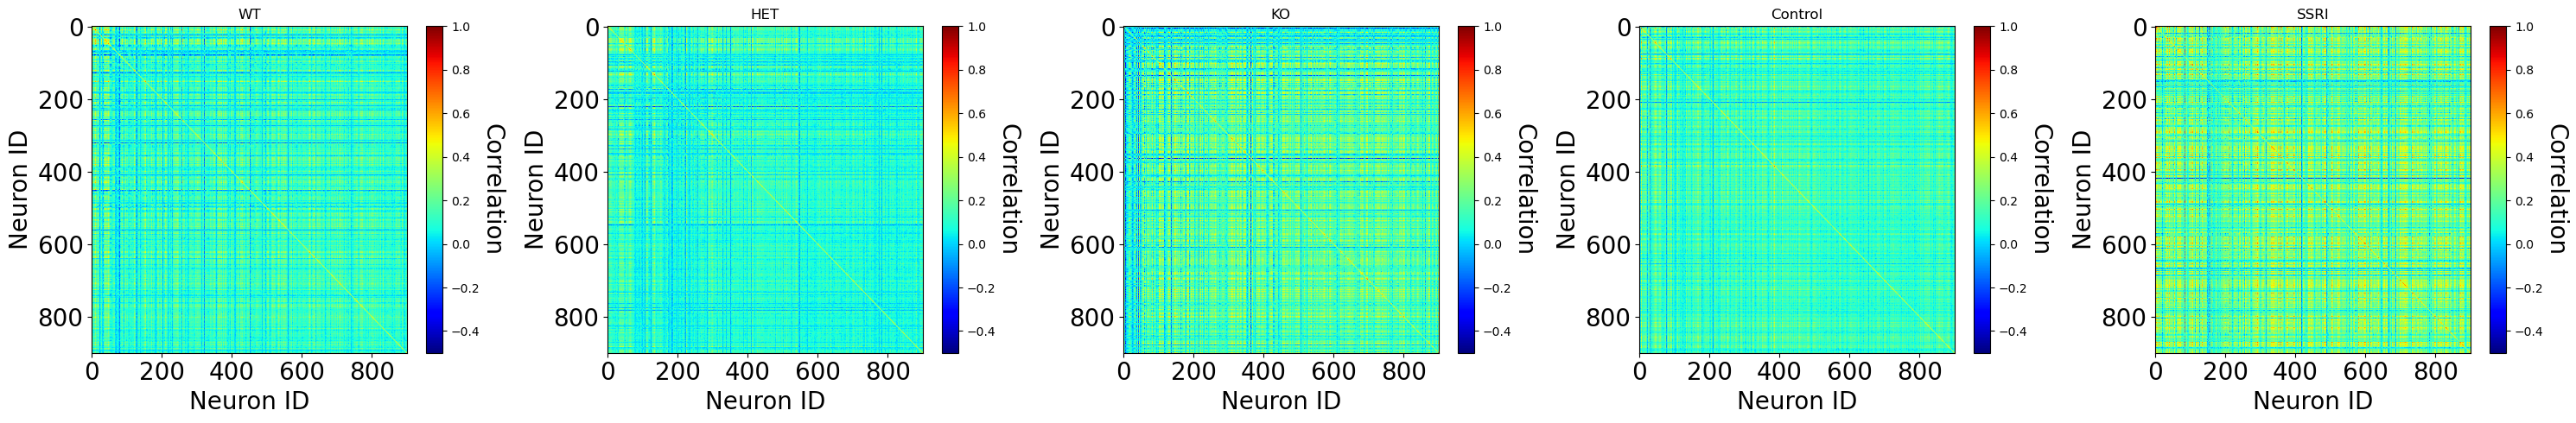

In [ ]:
#Heat map of corr
animal_list = ['GOS346','GOS331','GOS430','GOS408','GOS449']
plt.figure(figsize=(30,5))
for geno_count, count in enumerate(['WT','HET','KO','Control','SSRI']):
    corr = np.corrcoef(np.nanmean(df[df['animal'] == animal_list[geno_count]]['PeriF_av'].iloc[0][0,:900,:,60:270],axis=1))
    plt.subplot(1,5,geno_count+1)
    plt.imshow(corr,aspect='auto',cmap='jet', vmin = -0.50, vmax = 1)
    plt.title(count)
    colorbar = plt.colorbar()
    colorbar.set_label('Correlation', rotation=270,labelpad=20,fontsize=20)
    plt.xticks(np.arange(0,801,200),fontsize=20)
    plt.yticks(np.arange(0,801,200),fontsize=20)
    plt.ylabel('Neuron ID', fontsize=20)
    plt.xlabel('Neuron ID', fontsize=20)
plt.tight_layout()
plt.savefig(Save_path + 'Heat_map_corr_single_whisker.svg',bbox_inches='tight',dpi = 300,format='svg')


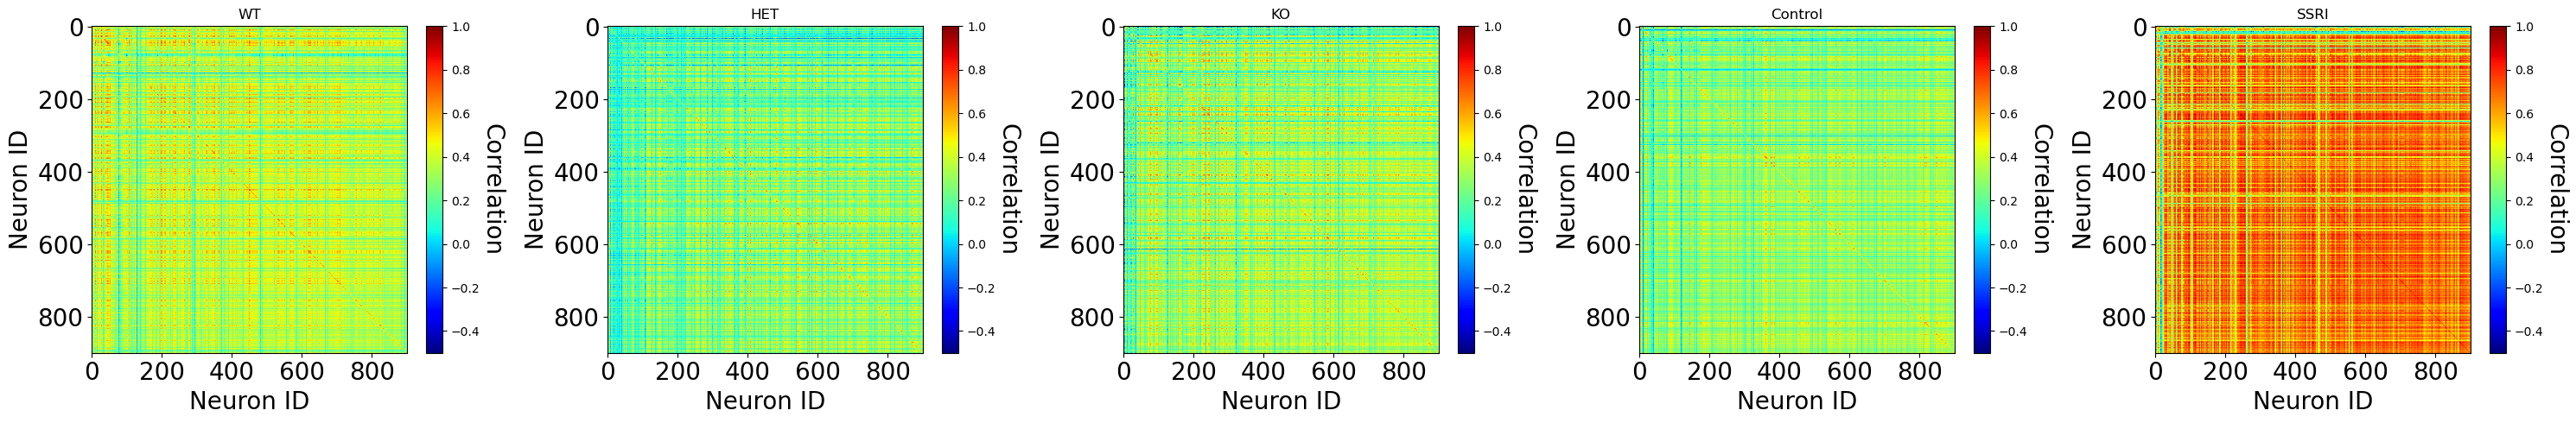

In [ ]:
#Heat map of corr
animal_list = ['GOS346','GOS348','GOS431','GOS408','GOS449']
plt.figure(figsize=(30,5))
for geno_count, count in enumerate(['WT','HET','KO','Control','SSRI']):
    corr = np.corrcoef(np.nanmean(df[df['animal'] == animal_list[geno_count]]['PeriF_av'].iloc[0][5,:900,:,60:270],axis=1))
    plt.subplot(1,5,geno_count+1)
    plt.imshow(corr,aspect='auto',cmap='jet', vmin = -0.50, vmax = 1)
    plt.title(count)
    colorbar = plt.colorbar()
    colorbar.set_label('Correlation', rotation=270,labelpad=20,fontsize=20)
    plt.xticks(np.arange(0,801,200),fontsize=20)
    plt.yticks(np.arange(0,801,200),fontsize=20)
    plt.ylabel('Neuron ID', fontsize=20)
    plt.xlabel('Neuron ID', fontsize=20)
plt.tight_layout()
#savefig
plt.savefig(Save_path + 'Heat_map_corr_airpuff.svg',bbox_inches='tight',dpi = 300,format='svg')

In [266]:
df['max'] = None
for i, row in df.iterrows():
    try:
        df.at[i,'max'] = np.max(row['av'][:,60:360],1) # Mean across cells, amplitude of that, and then average across repeats, will look at single cell later
    except:
        print('Something went wrong with ' + row['filepath'])
        pass

Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-03-09/2023-03-09_GOS301_t-00


In [311]:
df['Single_w_max'] = None
for i, row in df.iterrows():
    try:
        df.at[i,'Single_w_max'] = row['max'][5]
        #print(row['max'][0])
    except:
        print('Something went wrong with ' + row['filepath'])
        pass

Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-03-09/2023-03-09_GOS301_t-00


ShapiroResult(statistic=0.9315096139907837, pvalue=0.5918093323707581)
Ttest_indResult(statistic=-2.36396356073789, pvalue=0.04567476091771842)


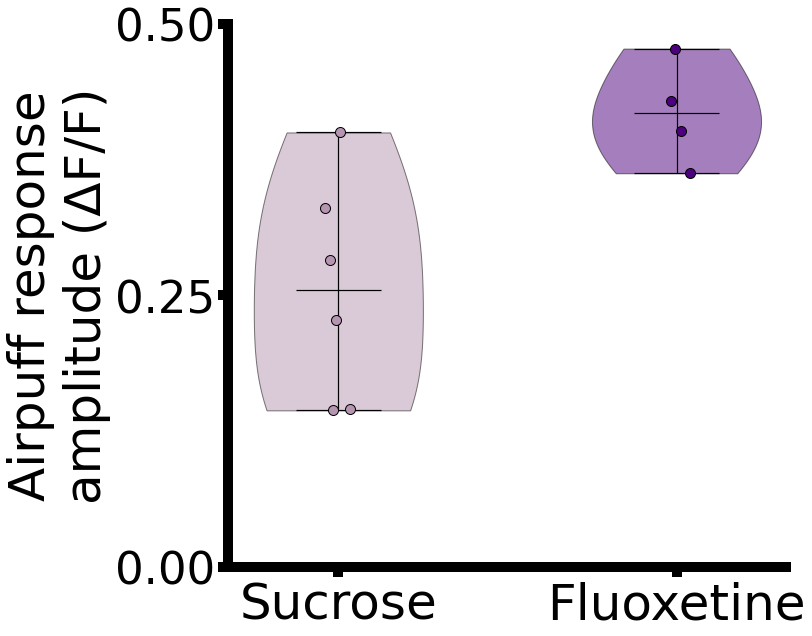

In [ ]:
plt.figure(figsize=(10,10))
df_tmp = df.copy()
#Replace 'Genotype' column name with 'genotype'
df_tmp = df_tmp.rename(columns={'Genotype': 'genotype'})
df_tmp = df_tmp[df_tmp['Single_w_Responsive_neurons'] > 0.05]

PdA.violin_plot(df_tmp,'Single_w_max',genotypes = ['Control','SSRI'],y_label ='Airpuff response\namplitude (ΔF/F)',color = [color4,color5],fontsize=50)
plt.yticks(np.arange(0,0.51,0.25),fontsize=45)
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=50)
print(stats.shapiro(df_tmp[df_tmp['genotype'] == 'Control']['Single_w_max']))
#ttest
print(stats.ttest_ind(df_tmp[df_tmp['genotype'] == 'Control']['Single_w_max'],df_tmp[df_tmp['genotype'] == 'SSRI']['Single_w_Responsive_neurons']))
#make column float
df_tmp['Single_w_max'] = df_tmp['Single_w_max'].astype(float)
plt.savefig(Save_path + 'airpuff_amplitude.svg',dpi=300,bbox_inches='tight',format='svg')

In [319]:
df['Single_w_max'] = None
for i, row in df.iterrows():
    try:
        df.at[i,'Single_w_max'] = row['max'][0]
        #print(row['max'][0])
    except:
        print('Something went wrong with ' + row['filepath'])
        pass

Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-03-09/2023-03-09_GOS301_t-00


ShapiroResult(statistic=0.9249272346496582, pvalue=0.5415353178977966)
Ttest_indResult(statistic=-3.9086789461800815, pvalue=0.004489395785852031)


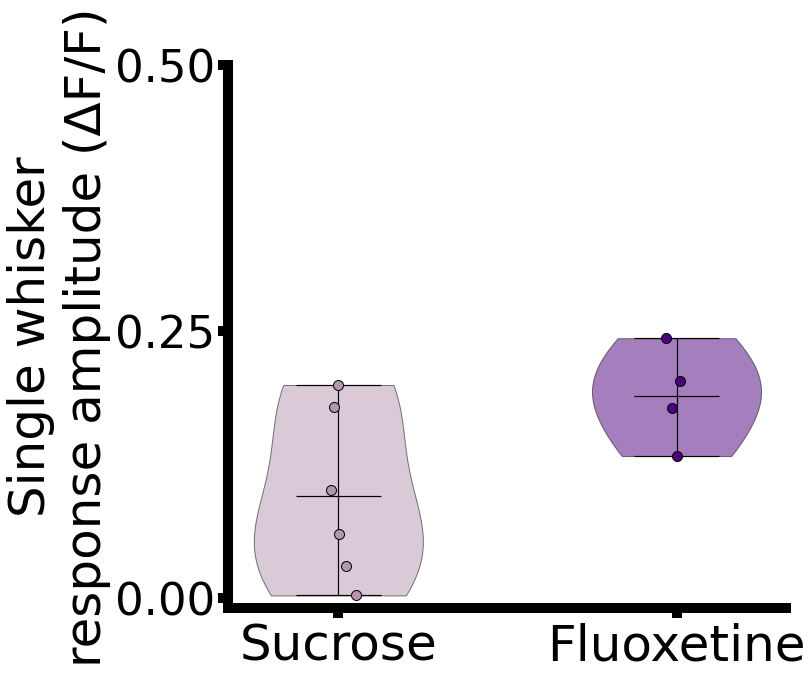

In [ ]:
plt.figure(figsize=(10,10))
df_tmp = df.copy()
#Replace 'Genotype' column name with 'genotype'
df_tmp = df_tmp.rename(columns={'Genotype': 'genotype'})
#Remove nones
df_tmp = df_tmp[df_tmp['Single_w_max'].notna()]
#Remove zeros
df_tmp = df_tmp[df_tmp['Single_w_Responsive_neurons'] > 0.05]
#df_tmp = df_tmp[df_tmp['Single_w_max'] > 0.0]
#df_tmp = df_tmp[df_tmp['num_cells'] > 300]
PdA.violin_plot(df_tmp,'Single_w_max',genotypes = ['Control','SSRI'],y_label ='Single whisker\nresponse amplitude (ΔF/F)',color = [color4,color5],fontsize=50)
plt.yticks(np.arange(0,0.51,0.25),fontsize=45)
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=50)
print(stats.shapiro(df_tmp[df_tmp['genotype'] == 'Control']['Single_w_max']))
#ttest
print(stats.ttest_ind(df_tmp[df_tmp['genotype'] == 'Control']['Single_w_max'],df_tmp[df_tmp['genotype'] == 'SSRI']['Single_w_Responsive_neurons']))
#make column float
df_tmp['Single_w_max'] = df_tmp['Single_w_max'].astype(float)

plt.savefig(Save_path + 'single_w_amplitude.svg',dpi=300,bbox_inches='tight',format='svg')

In [321]:
df['max'] = None
for i, row in df.iterrows():
    try:
        df.at[i,'max'] = np.nanmean(np.nanmean(np.max(row['PeriF_av'][:,:,:,60:360],axis = 3),axis=(2)),axis=1) # Mean across cells, amplitude of that, and then average across repeats, will look at single cell later
    except:
        print('Something went wrong with ' + row['filepath'])
        pass

C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_114472/1081943278.py:4: RuntimeWarning: Mean of empty slice
  df.at[i,'max'] = np.nanmean(np.nanmean(np.max(row['PeriF_av'][:,:,:,60:360],axis = 3),axis=(2)),axis=1) # Mean across cells, amplitude of that, and then average across repeats, will look at single cell later


Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-03-09/2023-03-09_GOS301_t-00


In [ ]:
df['Single_w_max'] = None
for i, row in df.iterrows():
    try:
        df.at[i,'Single_w_max'] = row['max'][5] #air puff
        #print(row['max'][0])
    except:
        print('Something went wrong with ' + row['filepath'])
        pass

Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-03-09/2023-03-09_GOS301_t-00


In [326]:
df['Single_w_max'] = None
for i, row in df.iterrows():
    try:
        df.at[i,'Single_w_max'] = row['max'][0]
        #print(row['max'][0])
    except:
        print('Something went wrong with ' + row['filepath'])
        pass

Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-03-09/2023-03-09_GOS301_t-00


In [23]:
df['av'] = None
for i, row in df.iterrows():
    try:
        df.at[i,'av'] = np.nanmean(row['PeriF_av'],axis=(1,2))
    except:
        print('Something went wrong with ' + row['filepath'])
        pass

C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_114472/908394391.py:4: RuntimeWarning: Mean of empty slice
  df.at[i,'av'] = np.nanmean(row['PeriF_av'],axis=(1,2))


Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-03-09/2023-03-09_GOS301_t-00


In [39]:
df['num_cells'] = None
for i, row in df.iterrows():
    try:
        df.at[i,'num_cells'] = row['PeriF_av'].shape[1]
    except:
        print('Something went wrong with ' + row['filepath'])
        pass

Something went wrong with //qnap-amp001.dpag.ox.ac.uk/gsantero/Data/2023-03-09/2023-03-09_GOS301_t-00


In [53]:
df['Responsiveness'] = None
for i, row in df.iterrows():
    try:
        df.at[i,'Responsiveness'] = An.responsiveness(row['PeriF_av'])
    except:
        print('Something went wrong with ' + row['filepath'])
        pass

c:\Users\gabrielos\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\gabrielos\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\CaAnaly.py:574: RuntimeWarning: Mean of empty slice
  meanarray[:,:,0] = np.nanmean(whisker_in_stim_resp[:,:,pre_window_1:pre_window_2],axis=2)
c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\CaAnaly.py:576: RuntimeWarning: Mean of empty slice
  meanarray[:,:,1] = np.nanmean(whisker_in_stim_resp[:,:,post_window_1:post_window_2],axis=2)


In [313]:
df['Single_w_Responsive_neurons'] = None
for i, row in df.iterrows():
    try:
        df.at[i,'Single_w_Responsive_neurons'] = row['Responsiveness'][0,10]
    except:
        print('Something went wrong with ' + row['filepath'])
        pass

ShapiroResult(statistic=0.7952097654342651, pvalue=0.05319848656654358)
Ttest_indResult(statistic=-2.589026598687558, pvalue=0.03216174200535663)


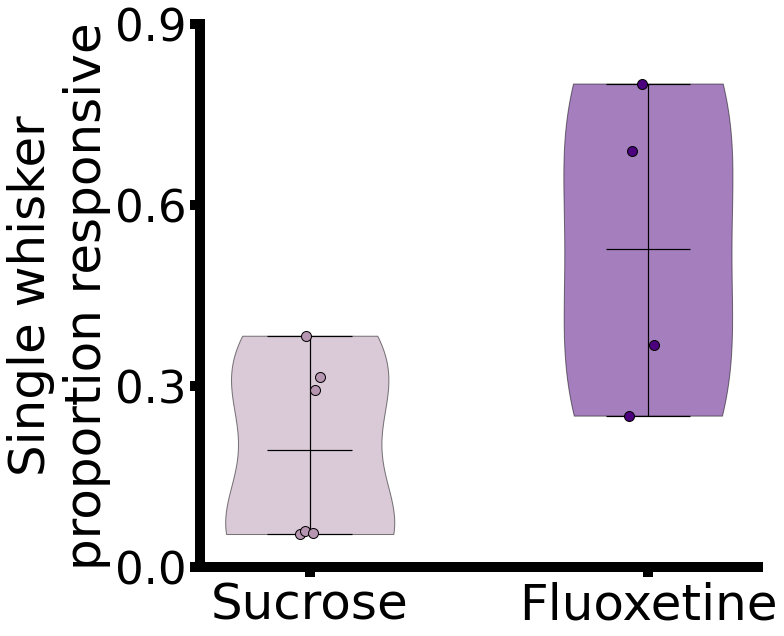

In [314]:
plt.figure(figsize=(10,10))
df_tmp = df.copy()
#Replace 'Genotype' column name with 'genotype'
df_tmp = df_tmp.rename(columns={'Genotype': 'genotype'})
#Remove nones
df_tmp = df_tmp[df_tmp['Single_w_Responsive_neurons'].notna()]
#Remove zeros
df_tmp = df_tmp[df_tmp['Single_w_Responsive_neurons'] > 0.05]
#df_tmp = df_tmp[df_tmp['num_cells'] > 600]
PdA.violin_plot(df_tmp,'Single_w_Responsive_neurons',genotypes = ['Control','SSRI'],y_label ='Single whisker\nproportion responsive',color = [color4,color5],fontsize=50)
plt.yticks(np.arange(0,0.91,0.3),fontsize=45)
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=50)
print(stats.shapiro(df_tmp[df_tmp['genotype'] == 'Control']['Single_w_Responsive_neurons']))
#ttest
print(stats.ttest_ind(df_tmp[df_tmp['genotype'] == 'Control']['Single_w_Responsive_neurons'],df_tmp[df_tmp['genotype'] == 'SSRI']['Single_w_Responsive_neurons']))
#make column float
df_tmp['Single_w_Responsive_neurons'] = df_tmp['Single_w_Responsive_neurons'].astype(float)
##mann whitney
#print(stats.mannwhitneyu(df_tmp[df_tmp['genotype'] == 'Control']['Single_w_Responsive_neurons'],df_tmp[df_tmp['genotype'] == 'SSRI']['Single_w_Responsive_neurons']))
plt.savefig(Save_path + 'single_w_Responsive_neurons.svg',dpi=300,bbox_inches='tight',format='svg')

In [298]:
df['Single_w_Responsive_neurons'] = None
for i, row in df.iterrows():
    try:
        df.at[i,'Single_w_Responsive_neurons'] = row['Responsiveness'][5,10]
    except:
        print('Something went wrong with ' + row['filepath'])
        pass

ShapiroResult(statistic=0.9464101195335388, pvalue=0.6969495415687561)
Ttest_indResult(statistic=-3.5087436624847617, pvalue=0.006631705972503202)


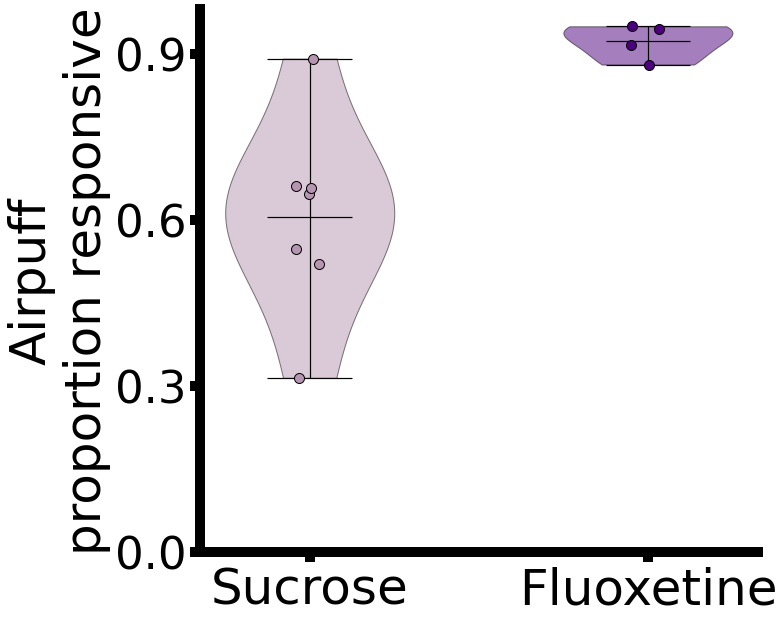

In [299]:
plt.figure(figsize=(10,10))
df_tmp = df.copy()
#Replace 'Genotype' column name with 'genotype'
df_tmp = df_tmp.rename(columns={'Genotype': 'genotype'})
#Remove nones
df_tmp = df_tmp[df_tmp['Single_w_Responsive_neurons'].notna()]
#Remove zeros
df_tmp = df_tmp[df_tmp['Single_w_Responsive_neurons'] > 0.00]
#df_tmp = df_tmp[df_tmp['num_cells'] > 600]
PdA.violin_plot(df_tmp,'Single_w_Responsive_neurons',genotypes = ['Control','SSRI'],y_label ='Airpuff\nproportion responsive',color = [color4,color5],fontsize=50)
plt.yticks(np.arange(0,0.91,0.3),fontsize=45)
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=50)
print(stats.shapiro(df_tmp[df_tmp['genotype'] == 'Control']['Single_w_Responsive_neurons']))
#ttest
print(stats.ttest_ind(df_tmp[df_tmp['genotype'] == 'Control']['Single_w_Responsive_neurons'],df_tmp[df_tmp['genotype'] == 'SSRI']['Single_w_Responsive_neurons']))
#make column float
df_tmp['Single_w_Responsive_neurons'] = df_tmp['Single_w_Responsive_neurons'].astype(float)
##mann whitney
#print(stats.mannwhitneyu(df_tmp[df_tmp['genotype'] == 'Control']['Single_w_Responsive_neurons'],df_tmp[df_tmp['genotype'] == 'SSRI']['Single_w_Responsive_neurons']))

plt.savefig(Save_path + 'Airpuff_w_Responsive_neurons.svg',dpi=300,bbox_inches='tight',format='svg')

C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_114472/1146602713.py:31: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(WT[:,y,:]-np.nanmean(WT[:,y,:60]),axis=0),label='WT',color=color1,lw=6)
C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_114472/1146602713.py:33: RuntimeWarning: Mean of empty slice
  plt.fill_between(np.arange(0,670),np.nanmean(WT[:,y,:]-np.nanmean(WT[:,y,:60]),axis=0)-sp.stats.sem(WT[:,y,:]-np.nanmean(WT[:,y,:60]),axis=0),
C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_114472/1146602713.py:34: RuntimeWarning: Mean of empty slice
  np.nanmean(WT[:,y,:]-np.nanmean(WT[:,y,:60]),axis=0)+sp.stats.sem(WT[:,y,:]-np.nanmean(WT[:,y,:60]),axis=0),alpha=0.2,color=color1)
C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_114472/1146602713.py:35: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(HET[:,y,:]-np.nanmean(HET[:,y,:60]),axis=0),label='HET',color=color2,lw=6)
C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_114472/1146602713.py:36: RuntimeWarning: Mean of em

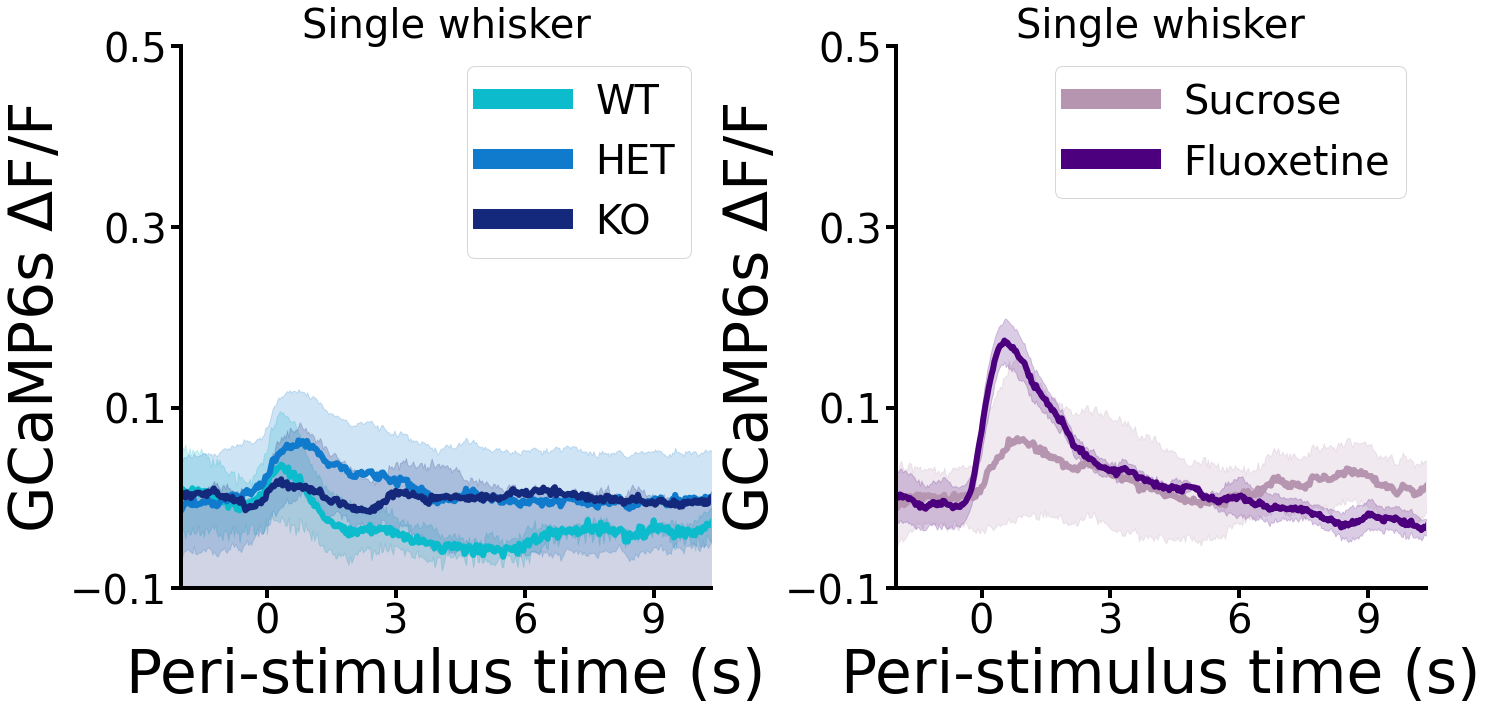

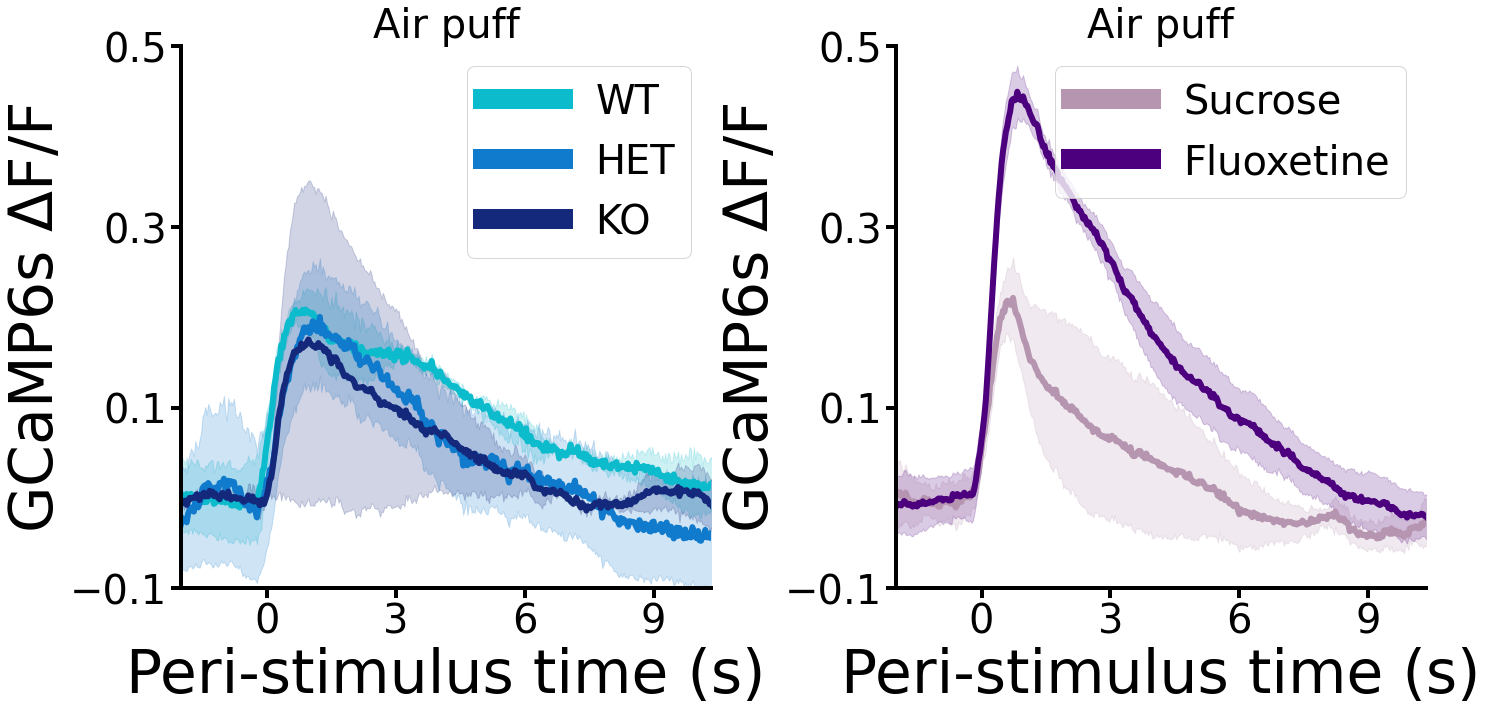

In [307]:
trials = ['Single whisker','Baseline','Rough','Multiwhisker','Smooth','Air puff','Sound']
#iterate thorugh the data frame and store the PeriF in an array for each genotype, by stacking
#the PeriF of each animal
WT = np.zeros([0,7,670])
HET = np.zeros([0,7,670])
KO = np.zeros([0,7,670])
Control = np.zeros([0,7,670])
SSRI = np.zeros([0,7,670])

for i, row in df.iterrows():
    #if PeriF is not nan of none
    if (row['av'] is not None) and (np.isnan(row['av']).all() == False) and (row['Single_w_Responsive_neurons']>0.1):  #(row['num_cells'] > 300)

    
        #print(row['genotype'])
        if row['Genotype'] == 'WT':
            WT = np.vstack([WT,np.reshape(row['av'],(1,7,670))])
        elif row['Genotype'] == 'HET':
            HET = np.vstack([HET,np.reshape(row['av'],(1,7,670))])
        elif row['Genotype'] == 'KO':
            KO = np.vstack([KO,np.reshape(row['av'],(1,7,670))])
        elif row['Genotype'] == 'Control':
            Control = np.vstack([Control,np.reshape(row['av'],(1,7,670))])
        elif row['Genotype'] == 'SSRI':
            SSRI = np.vstack([SSRI,np.reshape(row['av'],(1,7,670))])

#Plot trial 6 of WT, HET, KO and trial 7 of Control and SSRI together with shdaded SEM in a single plot
for y in [0,5]:
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.plot(np.nanmean(WT[:,y,:]-np.nanmean(WT[:,y,:60]),axis=0),label='WT',color=color1,lw=6)
    #plot shaded area for the standard error of the mean
    plt.fill_between(np.arange(0,670),np.nanmean(WT[:,y,:]-np.nanmean(WT[:,y,:60]),axis=0)-sp.stats.sem(WT[:,y,:]-np.nanmean(WT[:,y,:60]),axis=0),
                    np.nanmean(WT[:,y,:]-np.nanmean(WT[:,y,:60]),axis=0)+sp.stats.sem(WT[:,y,:]-np.nanmean(WT[:,y,:60]),axis=0),alpha=0.2,color=color1)
    plt.plot(np.nanmean(HET[:,y,:]-np.nanmean(HET[:,y,:60]),axis=0),label='HET',color=color2,lw=6)
    plt.fill_between(np.arange(0,670),np.nanmean(HET[:,y,:]-np.nanmean(HET[:,y,:60]),axis=0)-sp.stats.sem(HET[:,y,:]-np.nanmean(HET[:,y,:60]),axis=0),
                    np.nanmean(HET[:,y,:]-np.nanmean(HET[:,y,:60]),axis=0)+sp.stats.sem(HET[:,y,:]-np.nanmean(HET[:,y,:60]),axis=0),alpha=0.2, color=color2)
    plt.plot(np.nanmean(KO[:,y,:]-np.nanmean(KO[:,y,:60]),axis=0),label='KO',color=color3,lw=6)
    plt.fill_between(np.arange(0,670),np.nanmean(KO[:,y,:]-np.nanmean(KO[:,5,:60]),axis=0)-sp.stats.sem(KO[:,y,:]-np.nanmean(KO[:,y,:60]),axis=0),
                    np.nanmean(KO[:,y,:]-np.nanmean(KO[:,y,:60]),axis=0)+sp.stats.sem(KO[:,y,:]-np.nanmean(KO[:,y,:60]),axis=0),alpha=0.2, color=color3)
    plt.subplot(1,2,2)
    plt.plot(np.nanmean(Control[:,y,:]-np.nanmean(Control[:,y,:60]),axis=0),label='Sucrose',color=color4,lw=6)
    plt.fill_between(np.arange(0,670),np.nanmean(Control[:,y,:]-np.nanmean(Control[:,y,:60]),axis=0)-sp.stats.sem(Control[:,y,:]-np.nanmean(Control[:,y,:60]),axis=0),
                    np.nanmean(Control[:,y,:]-np.nanmean(Control[:,y,:60]),axis=0)+sp.stats.sem(Control[:,y,:]-np.nanmean(Control[:,y,:60]),axis=0),alpha=0.2,color=color4)
    plt.plot(np.nanmean(SSRI[:,y,:]-np.nanmean(SSRI[:,y,:60]),axis=0),label='Fluoxetine',color=color5,lw=6)
    plt.fill_between(np.arange(0,670),np.nanmean(SSRI[:,y,:]-np.nanmean(SSRI[:,y,:60]),axis=0)-sp.stats.sem(SSRI[:,y,:]-np.nanmean(SSRI[:,y,:60]),axis=0),
                    np.nanmean(SSRI[:,y,:]-np.nanmean(SSRI[:,y,:60]),axis=0)+sp.stats.sem(SSRI[:,y,:]-np.nanmean(SSRI[:,y,:60]),axis=0),alpha=0.2,color=color5)
    for i in range(1,3):
        plt.subplot(1,2,i)
        plt.title(trials[y],fontsize=40)
        leg = plt.legend(fontsize=40)
        for line in leg.get_lines():
            line.set_linewidth(20)
        #Remove top and right axis
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        #Make axis thicker
        plt.gca().spines['left'].set_linewidth(4)
        plt.gca().spines['bottom'].set_linewidth(4)
        #Make ticks bigger and longer
      
        plt.yticks(np.arange(-0.1,0.51,0.2),fontsize=40)
        plt.tick_params(width=4, length=10)
        #Replace xticks for -2,0,2,4,6,8,10, 12
        plt.xticks(np.arange(60, 370, 90), np.arange(0, 12, 3),fontsize=40)
        plt.xlabel('Peri-stimulus time (s)',fontsize=60)
        plt.ylabel('GCaMP6s ' + r'$\Delta$'+'F/F',fontsize=60)
        plt.xlim([0,370])
        if y==0:
            plt.ylim([-0.1,0.5])
        else:
            plt.ylim([-0.1,0.5])
    plt.tight_layout()
    plt.savefig(Save_path + 'PeriF_' + trials[y] + '.svg',dpi=300,format='svg',bbox_inches='tight')